In [43]:
# ライブラリ
from collections import deque
from matplotlib.animation import FuncAnimation
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import torch
import torch.nn as nn

In [44]:
# 日本語フォント
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

In [45]:
# 変数定義
L, Co, Ro = 50e-6, 1000e-6, 3  # インダクタンス、出力コンデンサ容量、負荷抵抗
Ts = 1 / 20e3  # スイッチング周期（20 kHz）
Tslen = 100  # 1周期あたりの分割数
dt = Ts / Tslen  # シミュレーション刻み幅
Vin, Vref = 28, 6  # 入力電圧、基準電圧
D0 = Vref / Vin  # 平均デューティ比
Tsim = 200 * Ts  # シミュレーション全体時間

print(L, Co, Ro, Ts, Tslen, dt, Vin, Vref, D0, Tsim)

5e-05 0.001 3 5e-05 100 5e-07 28 6 0.21428571428571427 0.01


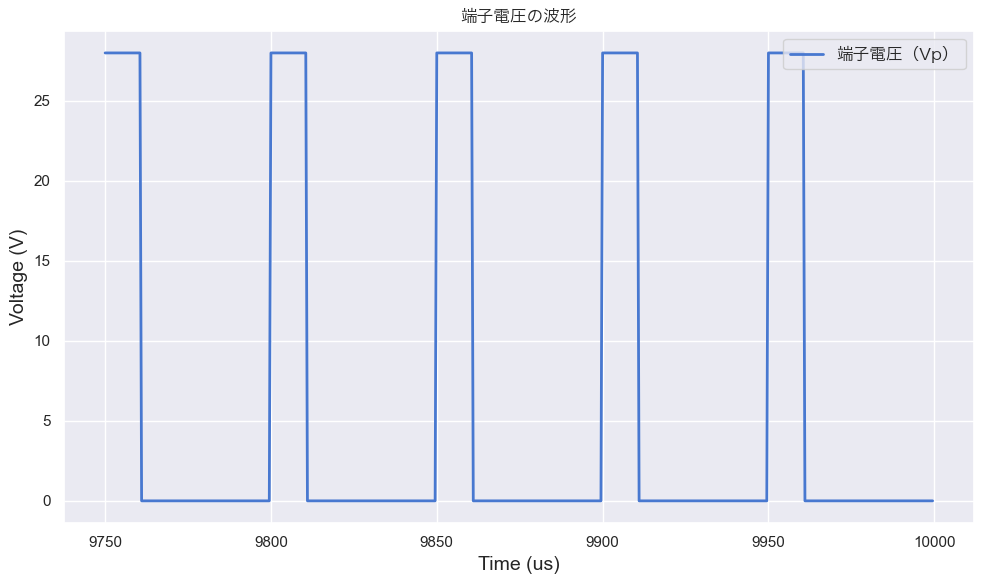

In [46]:
# ================================================
# 入力電圧波形の生成、プロット
# ================================================
def duty_cycle_mod(D0, Vin, dt, Tsim, Ts):
    """
    バックコンバータの変調戦略として
    デューティ比 D0 で方形波を生成し、負部分を 0 にクリップ。
    Vin をかけて端子電圧vpを作る。
    """
    t = np.linspace(0, Ts, round(Ts / dt), endpoint=False)
    s_pri = deque(signal.square(2 * np.pi / Ts * t, D0))
    vp = np.array(s_pri).clip(0, 1) * Vin
    vp = np.tile(vp, (round(Tsim / Ts),))
    return vp


vp = duty_cycle_mod(D0, Vin, dt, Tsim, Ts)
t = np.arange(0, len(vp) * dt, dt)

# 生成したvpをマイクロ秒単位の時間軸でプロット
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

plt.plot(
    t[-5 * Tslen :] * 1e6,
    vp[-5 * Tslen :],
    label="端子電圧（Vp）",
    color=sns.color_palette("muted")[0],
    linestyle="-",
    linewidth=2,
)
plt.legend(loc="upper right", fontsize=12, prop=font_prop)

plt.title("端子電圧の波形", fontsize=18, weight="bold", fontproperties=font_prop)
plt.xlabel("Time (us)", fontsize=14)
plt.ylabel("Voltage (V)", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# PANN（後述）への入力は (バッチサイズ×シーケンス長×入力次元) の形式
inputs = vp[None, :, None]  # 1×T×1 の配列に変形
assert inputs.shape == (1, len(vp), 1)
inputs = torch.FloatTensor(inputs)  # Tensor 化


In [ ]:
# ＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝====
# PANNによる推論
# ＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝====
class PANN(nn.Module):
    """
    物理内包型アーキテクチャニューラルネットワーク（PANN）
    - EulerCell_Buck: Buck コンバータのオイラー刻みセル
    - Recurrent 構造に物理モデルを組み込み
    """

    def __init__(self, cell, **kwargs):
        super(PANN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, inputs, x):
        outputs = []
        _x = x[:, 0]  # stateの初期化
        for t in range(inputs.shape[1]):
            state_next = self.cell.forward(inputs[:, t, :], _x)
            _x = state_next  # 予測された状態（state_next）を現在の状態として更新
            outputs.append(_x)  # 予測された状態をoutputsに追加
        return torch.stack(outputs, dim=1)


class EulerCell_Buck(nn.Module):
    """
    従来型のBuckコンバータに対するPANNの陽的オイラーリカレントセルを定義
    """

    def __init__(self, dt, L, Co, Ro, **kwargs):
        super(EulerCell_Buck, self).__init__(**kwargs)
        self.dt = dt
        self.L = nn.Parameter(torch.Tensor([L]))
        self.Co = nn.Parameter(torch.Tensor([Co]))
        self.Ro = nn.Parameter(torch.Tensor([Ro]))

    def forward(self, inputs, states):
        # 陽的オイラー法
        # inputs : s_pri*Vin を表す
        # states : iL, vo を表す
        vo = states[:, 1]
        va = inputs[:, 0]  # 端子電圧
        idx = (inputs[:, 0] == 0) & (states[:, 0] <= 0)  # 離散導通モード（DCM）を評価
        va[idx] = vo[idx]
        iL_next = states[:, 0] + self.dt / self.L * (va - vo)  # iLの物理モデル
        iL_next = torch.relu(iL_next)  # DCMを考慮するためにtorch.reluを適用
        vC_next = states[:, 1] + self.dt / self.Co * (
            states[:, 0] - vo / self.Ro
        )  # vCの物理モデル
        return torch.stack((iL_next, vC_next), dim=1)


# セルとPANNを torch.jit.script でコンパイル（高速化）
# buck_Euler_cell = torch.jit.script(EulerCell_Buck(dt, L, Co, Ro))
# pann_buck = torch.jit.script(PANN(buck_Euler_cell))
buck_Euler_cell = EulerCell_Buck(dt, L, Co, Ro)
pann_buck = PANN(buck_Euler_cell)

# 初期状態（電流iL=0, 出力電圧vo=0）
state0 = torch.zeros((inputs.shape[0], 1, 2))

# 推論実行
pann_buck.eval()
with torch.no_grad():
    states = pann_buck(inputs, state0)
print(states.shape)

vo va = tensor([0.]) tensor([28.])
vo va = tensor([0.]) tensor([28.])
vo va = tensor([0.0001]) tensor([28.])
vo va = tensor([0.0004]) tensor([28.])
vo va = tensor([0.0008]) tensor([28.])
vo va = tensor([0.0014]) tensor([28.])
vo va = tensor([0.0021]) tensor([28.])
vo va = tensor([0.0029]) tensor([28.])
vo va = tensor([0.0039]) tensor([28.])
vo va = tensor([0.0050]) tensor([28.])
vo va = tensor([0.0063]) tensor([28.])
vo va = tensor([0.0077]) tensor([28.])
vo va = tensor([0.0092]) tensor([28.])
vo va = tensor([0.0109]) tensor([28.])
vo va = tensor([0.0127]) tensor([28.])
vo va = tensor([0.0147]) tensor([28.])
vo va = tensor([0.0168]) tensor([28.])
vo va = tensor([0.0190]) tensor([28.])
vo va = tensor([0.0214]) tensor([28.])
vo va = tensor([0.0239]) tensor([28.])
vo va = tensor([0.0266]) tensor([28.])
vo va = tensor([0.0294]) tensor([28.])
vo va = tensor([0.0323]) tensor([0.])
vo va = tensor([0.0354]) tensor([0.])
vo va = tensor([0.0384]) tensor([0.])
vo va = tensor([0.0415]) tensor([0.]

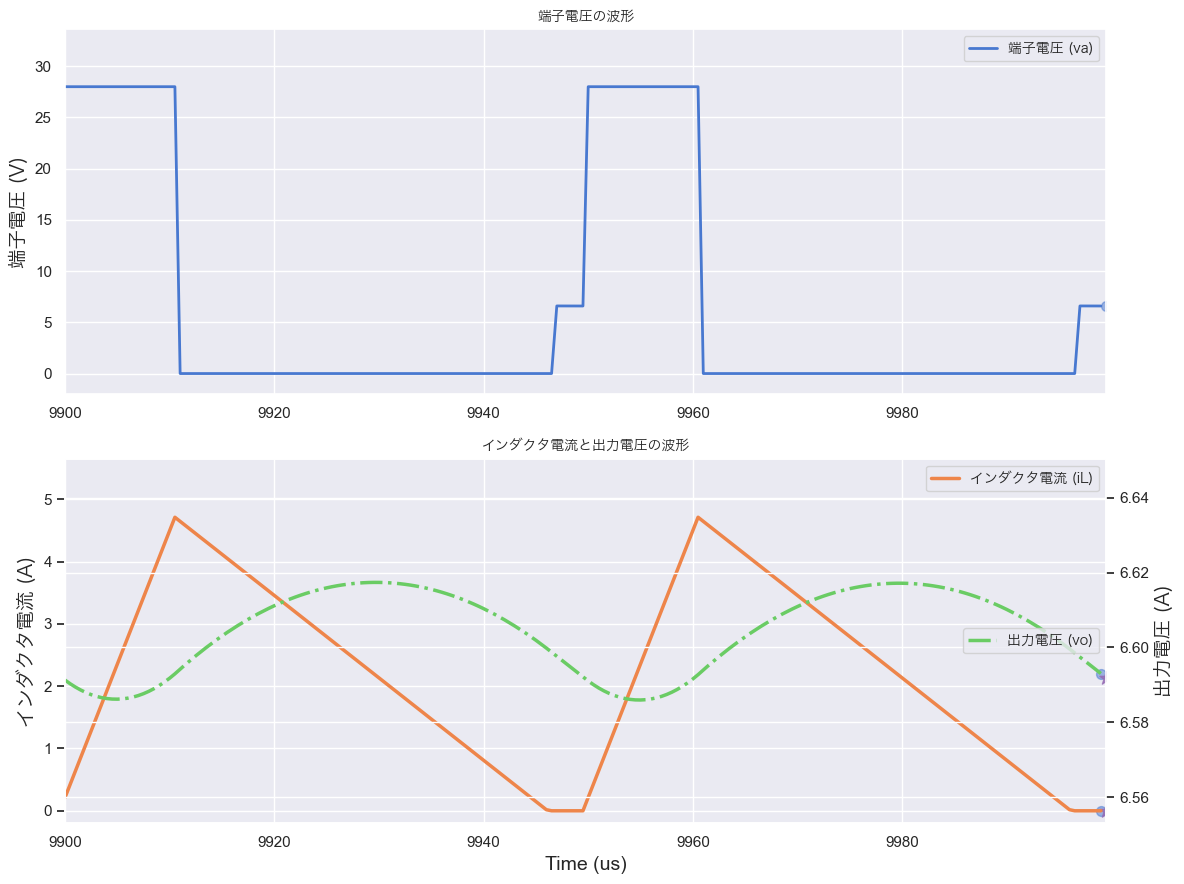

In [ ]:
# ================================================
# 推論結果の可視化(最後の2周期分だけ)
# ================================================
def create_gif_animation(t, inputs, states, Tslen, font_prop):
    if len(inputs.shape) == 3:
        t = t[-2 * Tslen :] * 1e6
        inputs = inputs[0, -2 * Tslen :]
        states = states[0, -2 * Tslen :]
    sns.set_theme(style="darkgrid")

    t, inputs, states = np.array(t), inputs.numpy(), states.numpy()
    vp, iL, vo = inputs[:, 0], states[:, 0], states[:, 1]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    ax22 = ax2.twinx()
    ax1.set_xlim(t.min(), t.max())
    ax1.set_ylim(-2, inputs.max() * 1.2)
    ax2.set_xlim(t.min(), t.max())
    ax2.set_ylim(-0.2, states[:, 0].max() * 1.2)
    ax22.set_ylim(states[:, 1].min() * 0.995, states[:, 1].max() * 1.005)

    ax1.set_title(
        "端子電圧の波形", fontsize=15, weight="bold", fontproperties=font_prop
    )
    ax2.set_title(
        "インダクタ電流と出力電圧の波形",
        fontsize=15,
        weight="bold",
        fontproperties=font_prop,
    )

    ax1.set_ylabel("端子電圧 (V)", fontsize=14, fontproperties=font_prop)
    ax2.set_xlabel("Time (us)", fontsize=14)
    ax2.set_ylabel("インダクタ電流 (A)", fontsize=14, fontproperties=font_prop)
    ax22.set_ylabel("出力電圧 (A)", fontsize=14, fontproperties=font_prop)

    (line1_1,) = ax1.plot(
        [],
        [],
        lw=2,
        label="端子電圧 (va)",
        color=sns.color_palette("muted")[0],
        linestyle="-",
    )
    (line2_1,) = ax2.plot(
        [],
        [],
        lw=2.5,
        label="インダクタ電流 (iL)",
        color=sns.color_palette("muted")[1],
        linestyle="-",
    )
    (line2_2,) = ax22.plot(
        [],
        [],
        lw=2.5,
        label="出力電圧 (vo)",
        color=sns.color_palette("muted")[2],
        linestyle="-.",
    )
    dot1_1 = ax1.scatter(
        [],
        [],
        edgecolor=sns.color_palette("muted")[0],
        alpha=0.5,
        s=50,
        color=sns.color_palette("muted")[0],
        marker="o",
    )
    dot2_1 = ax2.scatter(
        [],
        [],
        edgecolor=sns.color_palette("muted")[0],
        alpha=0.5,
        s=50,
        color=sns.color_palette("muted")[0],
        marker="o",
    )
    dot2_2 = ax22.scatter(
        [],
        [],
        edgecolor=sns.color_palette("muted")[0],
        alpha=0.5,
        s=50,
        color=sns.color_palette("muted")[0],
        marker="o",
    )
    dot2_3 = ax2.scatter(
        [],
        [],
        edgecolor=sns.color_palette("muted")[4],
        alpha=0.8,
        s=100,
        color=sns.color_palette("muted")[4],
        marker="*",
    )
    dot2_4 = ax22.scatter(
        [],
        [],
        edgecolor=sns.color_palette("muted")[4],
        alpha=0.8,
        s=100,
        color=sns.color_palette("muted")[4],
        marker="*",
    )

    ax1.grid(True)
    ax2.grid(True)
    ax1.legend(loc="upper right", fontsize=12, prop=font_prop)
    ax2.legend(loc="upper right", fontsize=12, prop=font_prop)
    ax22.legend(loc="center right", fontsize=12, prop=font_prop)

    def init():
        line1_1.set_data([], [])
        line2_1.set_data([], [])
        line2_2.set_data([], [])
        dot1_1.set_offsets(np.empty((0, 2)))
        dot2_1.set_offsets(np.empty((0, 2)))
        dot2_2.set_offsets(np.empty((0, 2)))
        dot2_3.set_offsets(np.empty((0, 2)))
        dot2_4.set_offsets(np.empty((0, 2)))
        return line1_1, line2_1, line2_2, dot1_1, dot2_1, dot2_2, dot2_3, dot2_4

    def update(frame):
        line1_1.set_data(t[: frame + 1], vp[: frame + 1])
        line2_1.set_data(t[: frame + 1], iL[: frame + 1])
        line2_2.set_data(t[: frame + 1], vo[: frame + 1])
        dot1_1.set_offsets(np.c_[t[frame + 1], vp[frame + 1]])
        dot2_1.set_offsets(np.c_[t[frame], iL[frame]])
        dot2_2.set_offsets(np.c_[t[frame], vo[frame]])
        dot2_3.set_offsets(np.c_[t[frame + 1], iL[frame + 1]])
        dot2_4.set_offsets(np.c_[t[frame + 1], vo[frame + 1]])

        return line1_1, line2_1, line2_2, dot1_1, dot2_1, dot2_2, dot2_3, dot2_4

    ani = FuncAnimation(
        fig, update, frames=inputs.shape[0] - 1, init_func=init, blit=False, interval=5
    )

    ani.save("Buck-inference.gif", writer="pillow")
    plt.tight_layout()
    plt.show()


create_gif_animation(t, inputs, states, Tslen, font_prop)